In [1]:
import pandas as pd

inv = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-08-10/investment.csv')

In [2]:
inv.head()

,category,meta_cat,group_num,year,gross_inv
0,Total basic infrastructure,Total infrastructure,1,1947,4974.662
1,Total basic infrastructure,Total infrastructure,1,1948,6486.770
2,Total basic infrastructure,Total infrastructure,1,1949,7376.143
3,Total basic infrastructure,Total infrastructure,1,1950,7943.959
4,Total basic infrastructure,Total infrastructure,1,1951,8961.233


In [3]:
inv.sample(10) # better than seeing just the first rows - see a sample of rows

,category,meta_cat,group_num,year,gross_inv
4598,S&L hospitals,Health,18,2001,2411.000
3819,S&L rail equipment,Air /water /other transportation,14,2003,378.562
6057,"Office buildings, NAICS 518 and 519",Digital,22,1969,9.000
4499,Private hospitals,Health,18,1973,2862.000
978,Transportation,Total basic infrastructure,4,2002,87596.314
5528,Federal,Public safety,21,2008,533.000
836,Conservation and development,Total basic infrastructure,4,2002,5167.483
1398,S&L,Conservation and development,7,1996,1801.000
4190,S&L,Social,16,1948,780.775
5447,Private,Public safety,21,1998,1262.000


In [4]:
inv['year'].describe() # 1947-2017

count    6106.00000
mean     1982.00000
std        20.49558
min      1947.00000
25%      1964.00000
50%      1982.00000
75%      2000.00000
max      2017.00000
Name: year, dtype: float64

In [5]:
inv['category'].value_counts() # more specific categories

Private                                                             710
S&L                                                                 639
Federal                                                             639
Transit                                                             142
Private other health structures                                      71
S&L equipment                                                        71
Private local transit structures                                     71
Private equipment                                                    71
Private natural gas pipelines                                        71
Private other railroad/track replacement structures                  71
Highways and streets                                                 71
Rail transportation                                                  71
S&L other educational structures                                     71
Other federal                                                   

In [6]:
inv['meta_cat'].value_counts() # this seems like a larger and more interpretable category

Air /water /other transportation    852
Transportation                      710
Total basic infrastructure          568
Health                              497
Total infrastructure                426
Education                           426
Electric power                      426
Social                              426
Public safety                       355
Digital                             355
Power                               213
Natural gas /petroleum power        213
Conservation and development        213
Highways and streets                142
Water supply                        142
Sewer and waste                     142
Name: meta_cat, dtype: int64

In [7]:
# in R tidyverse, this would be piped with %>%
# in Python, pandas, we can either create successive df changes
# or string together different functions

# Here we filter to the year 2017, group by the meta category, summarize (should drop the year because summary
# is not meaningful) and sorting by the gross investment

inv.loc[inv.year == 2017].groupby('meta_cat').agg(sum).sort_values(by = "gross_inv", ascending = False)

,group_num,year,gross_inv
meta_cat,,,
Total infrastructure,9,12102,1537628.616
Total basic infrastructure,29,16136,652366.200
Social,99,12102,490790.416
Transportation,117,20170,273022.556
Digital,110,10085,201735.000
Power,24,6051,147734.000
Health,126,14119,139898.207
Electric power,54,12102,126587.000
Education,114,12102,100055.000


<AxesSubplot:xlabel='year', ylabel='gross_inv'>

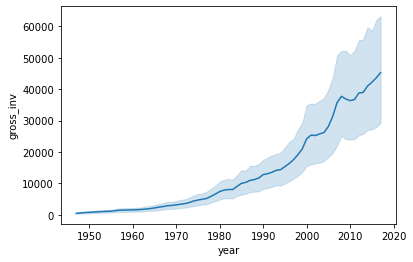

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.lineplot(x = 'year', y = 'gross_inv', data = inv)
# without specifying groups, seaborn shows the mean and 95% CI. Nice!

<AxesSubplot:xlabel='year', ylabel='gross_inv'>

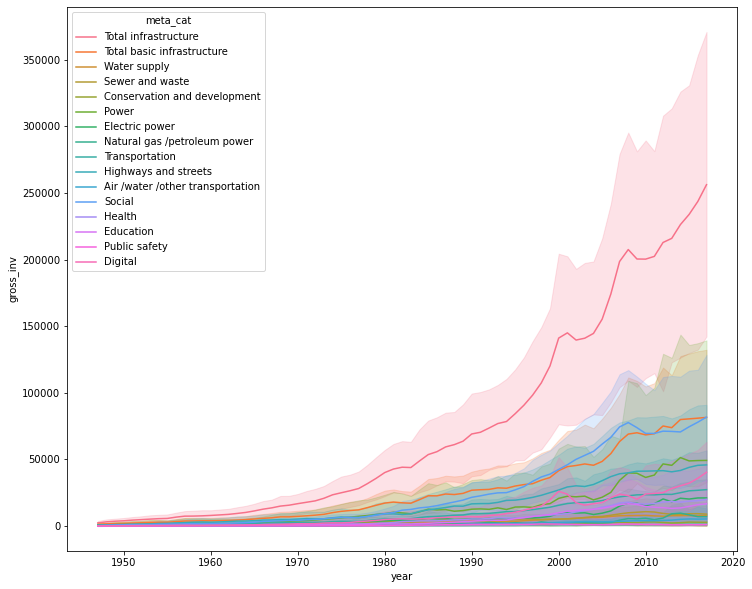

In [9]:
plt.figure(figsize=(12, 10)) # change plot size
sns.lineplot(x = 'year', y = 'gross_inv', hue = 'meta_cat', data = inv)

# Meta categories span different categories, so seaborn aggregates this as well.

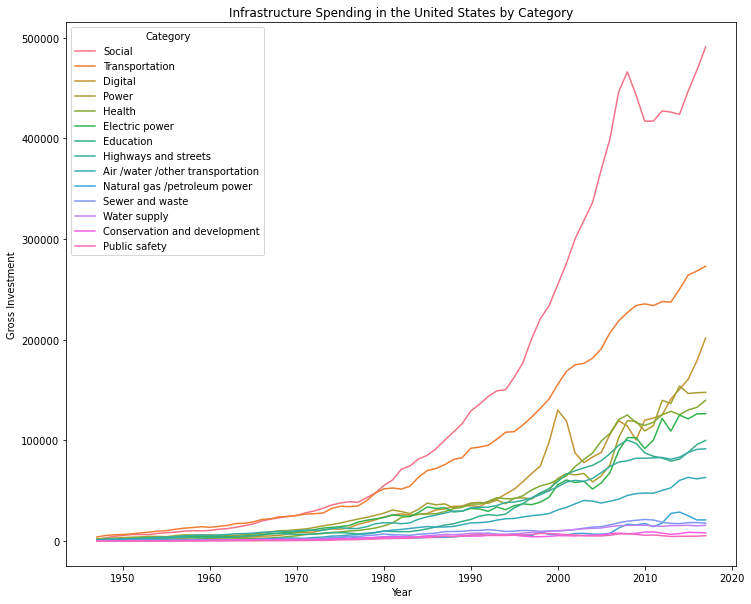

In [10]:
# it seems in Python successive steps to the same object are split into multiple lines for readability

inv_summary = inv[~inv.meta_cat.isin(['Total infrastructure', 'Total basic infrastructure'])]
# ~ = not true

inv_summary = inv_summary.groupby(['year', 'meta_cat'], as_index = False).agg(sum)
# pandas will convert the groups to an index - not very useful with two groups that I will need to
# subset later on

inv_summary = inv_summary.sort_values(by = "gross_inv", ascending = False)
# sorting seems like a useful step because the legend is sorted and the plot is much more readable

plt.figure(figsize=(12, 10)) # change plot size
sns.lineplot(x = 'year', y = 'gross_inv', hue = 'meta_cat', data = inv_summary)
plt.title('Infrastructure Spending in the United States by Category')
plt.xlabel('Year')
plt.ylabel('Gross Investment')
plt.legend(title = 'Category')

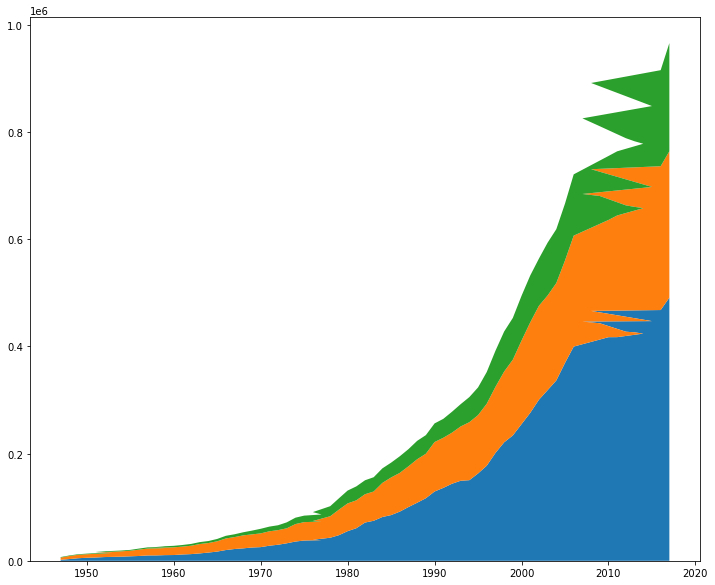

In [11]:
# In the plot above, it's clear what the rank order of spending is and that overall spending increased. 
# But did the proportion of various spending change over time?

# plt.stackplot requires each group to be a separate vector of values
# Not sure how this works with a grouped data frame (some issues with recent years)

social = inv_summary[inv_summary['meta_cat'] == 'Social'].gross_inv
transportation = inv_summary[inv_summary['meta_cat'] == 'Transportation'].gross_inv
digital = inv_summary[inv_summary['meta_cat'] == 'Digital'].gross_inv

plt.figure(figsize = (12, 10))
plt.stackplot(inv_summary[inv_summary['meta_cat'] == 'Social'].year,
              social, transportation, digital)

In [128]:
# How to get infrastructure as % of total?

# drop total categories, as before
inv_summary2 = inv[~inv.meta_cat.isin(['Total infrastructure', 'Total basic infrastructure'])]

# supply a dictionary to agg, this avoids summarizing the group index (not sure why that happens)
inv_summary2 = inv_summary2.groupby(['year', 'meta_cat']).agg({'gross_inv': 'sum'})

# to get percentages by year, group by the first level (year)
# and then apply a lambda function (anonymous function), dividing each row by the sum of each group
# to get percent of a single category by year
# from: https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby

inv_perc = inv_summary2.groupby(level=0).apply(lambda x: 100 * x / x.sum())

# flatten to dataframe
inv_perc = inv_perc.reset_index()

inv_perc.head()

,year,meta_cat,gross_inv
0,1947,Air /water /other transportation,3.456629
1,1947,Conservation and development,1.875848
2,1947,Digital,7.383658
3,1947,Education,2.975321
4,1947,Electric power,11.097757


In [102]:
# see matplot lib styles
print(plt.style.available)

11     1947
25     1948
39     1949
53     1950
67     1951
       ... 
935    2013
949    2014
963    2015
977    2016
991    2017
Name: year, Length: 71, dtype: int64

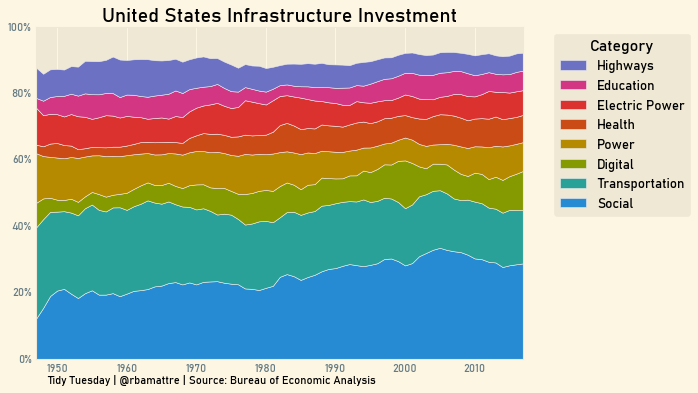

In [189]:
import matplotlib.ticker as mtick

# change global matplotlib style: https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('Solarize_Light2')

# set up font(s) - this sets the global sans-serif font (which is the default font family)
plt.rcParams['font.sans-serif'] = 'Bahnschrift'

# in seaborn, there is stacked distplot, but to do a stacked bar plot
# we need to plot each category separately (annoying)

# try the stackplot again

# I'm getting confused with ax versus plt - some methods are available in one but not the other
# it seems useful to create an axes and a figure (instead of just plotting)

social = inv_perc[inv_perc['meta_cat'] == 'Social'].gross_inv
transportation = inv_perc[inv_perc['meta_cat'] == 'Transportation'].gross_inv
digital = inv_perc[inv_perc['meta_cat'] == 'Digital'].gross_inv
highways = inv_perc[inv_perc['meta_cat'] == 'Highways and streets'].gross_inv
power = inv_perc[inv_perc['meta_cat'] == 'Power'].gross_inv
health = inv_perc[inv_perc['meta_cat'] == 'Health'].gross_inv
elec = inv_perc[inv_perc['meta_cat'] == 'Electric power'].gross_inv
ed = inv_perc[inv_perc['meta_cat'] == 'Education'].gross_inv

# set up labels
cat_labels = ['Social', 'Transportation', 'Digital', 'Power', 
                       'Health', 'Electric Power', 'Education', 'Highways']

# draw figure and axes (creates both fig and ax objects)
fig, ax = plt.subplots(figsize = (7, 5))

ax.stackplot(inv_perc[inv_perc['meta_cat'] == 'Social'].year,
              social, transportation, digital, power, health, elec, ed, highways,
             labels = cat_labels)
ax.ticklabel_format(useOffset=False) # don't use scientific notation on axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlim(1947, 2017)
# reverse labels for easier reading
# https://codeyarns.com/tech/2019-09-12-how-to-reverse-order-of-legend-in-matplotlib.html
ax.legend(reversed(plt.legend().legendHandles), reversed(cat_labels), loc='upper left',
          title = 'Category', title_fontsize = 'x-large', bbox_to_anchor=(1.05, 1))
#ax.set_position([0.08, 0.69, 0.95, 0.9])
ax.set_title('United States Infrastructure Investment', fontdict = {'fontsize': '18'})
# set annotation on the bottom
fig.text(0.1, 0.01, 'Tidy Tuesday | @rbamattre | Source: Bureau of Economic Analysis')
#plt.show()

plt.savefig('2021-08-13_infrastructure.png', bbox_inches = "tight", 
            facecolor = fig.get_facecolor(), edgecolor = 'none')
# make sure the bounding box with legend is included, and background color.
# No white border needed